In [1]:
!pip install pandas numpy matplotlib tqdm scikit-learn



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

json_path = '/content/drive/My Drive/user-transactions.json'

df = pd.read_json(json_path)
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [8]:

df = df.rename(columns={'userWallet': 'user'})

df['action'] = df['action'].str.lower()

df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date']     = df['datetime'].dt.date


print(df[['user', 'action', 'datetime']].head())


                                         user            action  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit   
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit   
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit   
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit   
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying   

             datetime  
0 2021-08-17 05:29:26  
1 2021-05-20 15:36:53  
2 2021-07-24 09:28:33  
3 2021-07-31 23:15:18  
4 2021-04-19 15:25:07  


In [9]:
import numpy as np
from tqdm import tqdm

def extract_features(df):
    wallets = df['user'].unique()
    rows = []

    for wallet in tqdm(wallets):
        u = df[df['user'] == wallet]

        deposit  = (u['action'] == 'deposit').sum()
        borrow   = (u['action'] == 'borrow').sum()
        repay    = (u['action'] == 'repay').sum()
        redeem   = (u['action'] == 'redeemunderlying').sum()
        liquid   = (u['action'] == 'liquidationcall').sum()

        total_tx = len(u)
        act_days = u['datetime'].dt.date.nunique()

        rows.append({
            'wallet'          : wallet,
            'deposit'         : deposit,
            'borrow'          : borrow,
            'repay'           : repay,
            'redeem'          : redeem,
            'liquidate'       : liquid,
            'total_txns'      : total_tx,
            'active_days'     : act_days,
            'repay_ratio'     : repay  / borrow  if borrow  else 0,
            'redeem_ratio'    : redeem / deposit if deposit else 0,
            'liquid_rate'     : liquid / total_tx if total_tx else 0,
        })

    return pd.DataFrame(rows)

features_df = extract_features(df)
features_df.head()


100%|██████████| 3497/3497 [00:57<00:00, 60.88it/s]


,wallet,deposit,borrow,repay,redeem,liquidate,total_txns,active_days,repay_ratio,redeem_ratio,liquid_rate
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,0,0,0,1,1,0.000000,0.00,0.0
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,0,0,0,1,1,0.000000,0.00,0.0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0,0,0,0,2,2,0.000000,0.00,0.0
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,0,0,17,0,17,8,0.000000,0.00,0.0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,15,4,130,0,399,104,0.266667,0.52,0.0


In [10]:
from sklearn.preprocessing import MinMaxScaler

def compute_scores(feats, w_repay=4, w_redeem=2, w_liquid=2, w_activity=2):
    """
    Turn engineered features into a 0‑1000 score.

    ‑ w_repay      : weight for repay_ratio  (higher = safer)
    ‑ w_redeem     : weight for redeem_ratio (higher = safer)
    ‑ w_liquid     : weight for (1‑liquid_rate) (lower liquidation = safer)
    ‑ w_activity   : weight for activity level (more active_days = safer)
    """
    raw = (
        feats['repay_ratio']            * w_repay +
        feats['redeem_ratio']           * w_redeem +
        (1 - feats['liquid_rate'])      * w_liquid +
        (feats['active_days'] /
         feats['active_days'].max())    * w_activity
    )

    scaler = MinMaxScaler(feature_range=(0, 1000))
    feats['credit_score'] = scaler.fit_transform(raw.values.reshape(-1, 1))
    return feats[['wallet', 'credit_score']]

scored_df = compute_scores(features_df)
scored_df.head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,5.499701
1,0x000000000051d07a4fb3bd10121a343d85818da6,5.499701
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.567599
3,0x0000000000e189dd664b9ab08a33c4839953852c,5.974984
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,20.503248


In [11]:
scored_df['credit_score'].describe()


,credit_score
count,3497.000000
mean,14.210896
std,23.488708
min,0.000000
25%,5.499701
50%,5.635496
75%,19.426242
max,1000.000000


count    3497.000000
mean       23.478879
std        23.363246
min         0.000000
25%        14.676901
50%        14.900294
75%        29.131711
max      1000.000000
Name: credit_score, dtype: float64


/tmp/ipython-input-12-2407584641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scored_df['range'] = pd.cut(scored_df['credit_score'], bins=np.arange(0, 1100, 100))


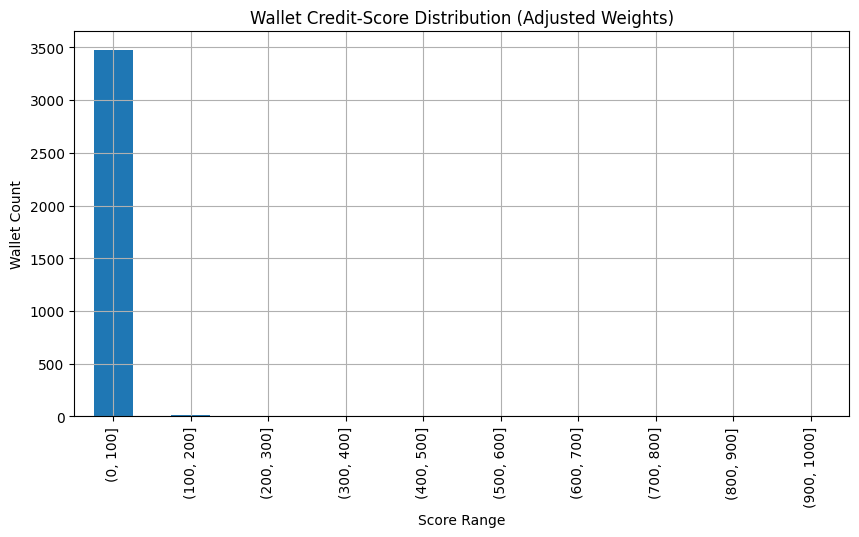

In [12]:

scored_df = compute_scores(
    features_df,
    w_repay   = 6,
    w_redeem  = 3,
    w_liquid  = 8,
    w_activity= 5


print(scored_df['credit_score'].describe())


import numpy as np, matplotlib.pyplot as plt
scored_df['range'] = pd.cut(scored_df['credit_score'], bins=np.arange(0, 1100, 100))
scored_df['range'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Wallet Credit‑Score Distribution (Adjusted Weights)')
plt.xlabel('Score Range'); plt.ylabel('Wallet Count'); plt.grid(True); plt.show()


In [13]:
final_path = '/content/drive/My Drive/wallet_scores_final.csv'
scored_df[['wallet', 'credit_score']].to_csv(final_path, index=False)
print("Saved →", final_path)


Saved → /content/drive/My Drive/wallet_scores_final.csv


In [16]:
!mkdir -p /content/src


In [17]:
%%writefile /content/src/score_wallets.py
import argparse, pathlib
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

def load_and_prepare(json_path):
    df = pd.read_json(json_path)
    df = df.rename(columns={'userWallet': 'user'})
    df['action'] = df['action'].str.lower()
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df['date'] = df['datetime'].dt.date
    return df

def engineer_features(df):
    rows = []
    for wallet, group in tqdm(df.groupby('user')):
        dep = (group['action'] == 'deposit').sum()
        bor = (group['action'] == 'borrow').sum()
        rep = (group['action'] == 'repay').sum()
        red = (group['action'] == 'redeemunderlying').sum()
        liq = (group['action'] == 'liquidationcall').sum()
        total = len(group)
        days = group['date'].nunique()
        rows.append({
            'wallet': wallet,
            'repay_ratio': rep / bor if bor else 0,
            'redeem_ratio': red / dep if dep else 0,
            'liquid_rate': liq / total if total else 0,
            'active_days': days
        })
    return pd.DataFrame(rows)

def compute_scores(features_df, w_repay=6, w_redeem=3, w_liquid=8, w_activity=5):
    raw = (
        features_df['repay_ratio'] * w_repay +
        features_df['redeem_ratio'] * w_redeem +
        (1 - features_df['liquid_rate']) * w_liquid +
        (features_df['active_days'] / features_df['active_days'].max()) * w_activity
    )
    raw = np.log1p(raw * 5)
    scaler = MinMaxScaler((0, 1000))
    features_df['credit_score'] = scaler.fit_transform(raw.values.reshape(-1, 1))
    return features_df[['wallet', 'credit_score']]

def plot_distribution(df, out_path):
    df = df.copy()
    df['range'] = pd.cut(df['credit_score'], bins=np.arange(0, 1100, 100))
    df['range'].value_counts().sort_index().plot.bar(figsize=(10, 5))
    plt.title('Wallet Credit Score Distribution')
    plt.xlabel('Score Range')
    plt.ylabel('Wallet Count')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    print("✓ Plot saved:", out_path)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--input', required=True, help='Path to input JSON file')
    parser.add_argument('--output', required=True, help='Path to save output CSV')
    args = parser.parse_args()

    print("⏳ Loading data...")
    df = load_and_prepare(args.input)

    print("⚙️  Engineering features...")
    features_df = engineer_features(df)

    print("📊 Computing scores...")
    scored_df = compute_scores(features_df)

    print("💾 Saving CSV...")
    scored_df.to_csv(args.output, index=False)
    print("✅ CSV saved:", args.output)

    print("📈 Saving plot...")
    plot_path = str(pathlib.Path(args.output).with_suffix('.png'))
    plot_distribution(scored_df, plot_path)


Writing /content/src/score_wallets.py


In [22]:
!find /content/drive/MyDrive -type f -iname "user-transactions.json"


/content/drive/MyDrive/user-transactions.json


In [23]:
!python /content/src/score_wallets.py \
  --input '/content/drive/MyDrive/user-transactions.json' \
  --output '/content/wallet_scores_final.csv'


⏳ Loading data...
⚙️  Engineering features...
100% 3497/3497 [00:02<00:00, 1408.32it/s]
📊 Computing scores...
💾 Saving CSV...
✅ CSV saved: /content/wallet_scores_final.csv
📈 Saving plot...
✓ Plot saved: /content/wallet_scores_final.png


In [25]:
from google.colab import files
files.download('/content/wallet_scores_final.csv')
files.download('/content/wallet_scores_final.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
files.download('/content/src/score_wallets.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>